# OR Tools for Robot & Drone VRP

##### **目標**

比較 **VRP**、**Drone VR**、**Robot VRP**、**Drone & Robot VRP**，四種組合在不同參數下的表現

##### **表現指標**
- 總路徑時間
- 總路徑長度
- 時間複雜度 (演算法計算時間)
- 空間複雜度 (記憶體使用量) 

##### **參數**
- 不同地圖大小 (5x5, 10x10, 15x15, 20x20, 25x25, 30x30)
- 不同客戶數量 (10, 20, 30, 40, 50, 60, 70, 80, 90, 100)，可以慢慢把 Node 數量增加，客戶數量大於 20 時考慮多台車輛
- 不同車輛數量 (1, 2, 3, 4)
- 蒙地卡羅模擬次數 1000 次

##### **實驗假設**

- 每個客戶點的貨物數量、尺寸皆相同
- 每個客戶點的服務時間皆為 1 分鐘
- 實驗載具共有 Truck、Drone 與 Robot 三種載具
- Drone 與 Robot 可以由 Truck 於任意客戶點中派出與回收，派出與回收各需要花費 1 分鐘
- 若 Truck 抵達回收點時 Drone 與 Robot 尚未返回，需記錄等待時間
- 一台車配置多台 Drone 與 Robot，且 Drone 與 Robot 可以同時在路上
- Truck 載具的速度為 60 km/hr，使用曼哈頓距離計算，載貨量為 **服務點 ÷ 車輛數** (考量平均工作量)
- Drone 載具的速度為 80 km/hr，使用歐式距離計算，每次只能載 1 個貨物, 電池續航力為 60 分鐘
- Robot 載具的速度為 30 km/hr，使用曼哈頓距離計算，每次只能載 4 個貨物, 電池續航力為 120 分鐘

##### **D&RVRP 路徑規劃流程**

1. 選擇分配給 Drone 的服務點

    - 篩選出最近點距離最遠的 n 個點作為 Drone 效益最高的點，**n 設定為第 25 百分位數**
    - 設定其最鄰近點為 Drone 的可能發收站，並排除掉 Node 為其他 Drone 發收站的點

2. 選擇分配給 Robot 的服務點

3. 未分配的點使用 OR-Tools 求解 Truck 路徑

4. 將 Drone 與 Robot 的路徑加入 Truck 路徑中

    - 決定 Drone 的發收站
    - 決定 Robot 的發收站
    - 需考量到最小回收站等待時間

In [1]:
import random as rd
import numpy as np
import pandas as pd
import math
import copy as copy
# OR-Tools
from ortools.constraint_solver import routing_enums_pb2 
from ortools.constraint_solver import pywrapcp 
# 記錄時間/空間複雜度
import time 
import tracemalloc
# 視覺化結果
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

## Parameters

In [2]:
# [實驗控制變數] 地圖大小 | 服務點數量 | 車輛數量
# MAX_X, MAX_Y = 25, 25 # km
# NUM_NODES = 30
# NUM_VEHICLES = 1

# 配送服務時間
SERVICE_TIME = 1

# [Vehicle]
# 時速 60km | 每台車有最大移動距離(固定) | 貨物重量相同 | 本實驗不考慮車輛成本, 故每台車可載貨物數量 = (站點/車輛數)
VEHICLE_SPEED = 60
VEHICLE_MAX_DISTANCE = 9999999
# VEHICLE_CAPACITIES = int(NUM_NODES / NUM_VEHICLES)

# [Drone]
# 時速 80km | 續航力 60 min | 採用歐幾里德距離 | 負責離群值 | 派出與收回載具各需要 1 分鐘
DRONE_SETUP_TIME = 1  # 發送 & 收回 Drone 的準備時間
DRONE_CAPACITIES = 1
DRONE_SPEED = 80
DRONE_BATTERY_LIFE = 60

# [Robot]
# 時速 30km | 續航力 120 min | 負責高密度點 | 派出與收回載具各需要 1 分鐘
ROBOT_SETUP_TIME = 1
ROBOT_CAPACITIES = 4
ROBOT_SPEED = 30
ROBOT_BATTERY_LIFE = 120

## Model

In [96]:
# dict(map_size=(20, 20), num_nodes=20, num_vehicle=1, trials=10)
def create_data_model(**controls):
    # np.random.seed(42)

    NUM_NODES = controls["num_nodes"]
    MAX_X, MAX_Y = controls["map_size"][0], controls["map_size"][1]
    NUM_VEHICLES = controls["num_vehicle"]
    VEHICLE_CAPACITIES = int(controls["num_nodes"] / controls["num_vehicle"])
    
    data = {}
    data["num_locations"] = [(np.random.randint(1, MAX_X+1), np.random.randint(1, MAX_Y+1)) for i in range(NUM_NODES)]
    data["num_locations"][0] = (int(MAX_X / 2), int(MAX_Y / 2)) 
    data["distance_matrix"] = compute_manhattan_distance_matrix(data["num_locations"])
    data["e_distance_matrix"] = compute_euclidean_distance_matrix(data["num_locations"]) # 歐幾里德距離, 取小數第二位
    data["time_matrix"] = compute_time_matrix(data["distance_matrix"]) # 最小單位分鐘
    data["num_nodes"] = NUM_NODES
    data["num_vehicles"] = NUM_VEHICLES
    data["depot"] = 0 # Depot 的索引值
    data["time_windows"] = []
    data["initial_routes"] = [] # 如果有初始解可以套用
    data["demands"] = [1 for i in range(NUM_NODES)]
    data["demands"][0] = 0
    data["vehicle_capacities"] = [VEHICLE_CAPACITIES for i in range(NUM_VEHICLES)]

    # 三個載具負責的 node 索引值
    data["vehicle"] = []
    data["drone"] = []
    data["robot"] = []    
    return data

def compute_manhattan_distance_matrix(nodes):
    distance_matrix = []
    for node_i in nodes:
        distances = []
        for node_j in nodes:
            if node_i == node_j:
                distances.append(0)
            else:
                manhattan_distance = np.sum(np.abs(np.array(node_i) - np.array(node_j)))
                distances.append(manhattan_distance)
        distance_matrix.append(distances)
    return distance_matrix

def compute_euclidean_distance_matrix(nodes):
    distance_matrix = []
    for node_i in nodes:
        distances = []
        for node_j in nodes:
            if node_i == node_j:
                distances.append(0)
            else:
                euclidean_distance = np.sqrt((node_i[0] - node_j[0])**2 + (node_i[1] - node_j[1])**2)
                distances.append(round(euclidean_distance, 2))
        distance_matrix.append(distances)
    return distance_matrix

def compute_time_matrix(distance_matrix):
    time_matrix = []
    for i in distance_matrix:
        time_matrix.append(list(map(lambda x: int(x / VEHICLE_SPEED * 60), i)))
    return time_matrix

# 重置 Node 的貨物需求
def reset_demands(data, **controls):

    NUM_VEHICLES = controls["num_vehicle"]
    VEHICLE_CAPACITIES = int(controls["num_nodes"] / controls["num_vehicle"])
    data["demands"] = [1 for i in range(data["num_nodes"])]
    data["demands"][0] = 0
    data["vehicle_capacities"] = [VEHICLE_CAPACITIES for i in range(NUM_VEHICLES)]

    return data

# 將指定點的 data["demands"] 設置為 999
def exclude_nodes(data, nodes, routes):
    for node in nodes:
        data['demands'][node] = 999
        for index, route in enumerate(routes):
            if node in route:
                data['vehicle_capacities'][index] -= 1 # 將某 node 的需求變為 0
    return data

## Controller

In [37]:
# 取得目標值(時間和/分鐘): 提供路徑, 速度, 參考距離矩陣, 會考量每個點的服務時間
def get_objective_value(data, route, speed=VEHICLE_SPEED, matrix='distance_matrix'):
    objective_value = 0
    for i in range(len(route) - 1):
        objective_value += data[matrix][route[i]][route[i + 1]] + SERVICE_TIME
    objective_value = int(objective_value / speed * 60)
    return objective_value

# 提供索引值取得 node 的座標
def get_nodes(node_list):
    locations = []
    for i in node_list:
        locations.append(data['num_locations'][i])
    return locations

# 計算角度: 計算 Drone 的返回點, 讓等待最小化
def calculate_angle(locations):
    A, B, C = locations[0], locations[1], locations[2]
    vector_AB = [B[0] - A[0], B[1] - A[1]] # 計算向量 AB 和 BC
    vector_BC = [C[0] - B[0], C[1] - B[1]]
    dot_product = vector_AB[0] * vector_BC[0] + vector_AB[1] * vector_BC[1] # 計算向量的點積和模長
    magnitude_AB = math.sqrt(vector_AB[0]**2 + vector_AB[1]**2)
    magnitude_BC = math.sqrt(vector_BC[0]**2 + vector_BC[1]**2)
    angle_radians = math.acos(dot_product / (magnitude_AB * magnitude_BC)) # 計算角度(以弧度為單位)
    angle_degrees = math.degrees(angle_radians) # 轉換為角度(以度為單位)
    
    return angle_degrees

def print_solution(data, manager, routing, solution):
    """Prints solution on console."""
    print(f"Objective: {solution.ObjectiveValue()}")
    total_distance = 0
    total_load = 0

    for vehicle_id in range(data["num_vehicles"]):
        index = routing.Start(vehicle_id)
        plan_output = f"Route for vehicle {vehicle_id}:\n"
        route_distance = 0
        route_load = 0
        while not routing.IsEnd(index):
            node_index = manager.IndexToNode(index)
            route_load += data["demands"][node_index]
            plan_output += f" {node_index} ({route_distance}) -> "
            previous_index = index
            index = solution.Value(routing.NextVar(index))
            route_distance += routing.GetArcCostForVehicle(
                previous_index, index, vehicle_id
            )
        plan_output += f" {manager.IndexToNode(index)} ({route_distance})\n"
        plan_output += f"Distance of the route: {route_distance} km\n"
        plan_output += f"Load of the route: {route_load}\n"
        print(plan_output)
        total_distance += route_distance
        total_load += route_load
    
    print(f"Total distance of all routes: {total_distance} km")
    print(f"Total load of all routes: {total_load}")

# Save routes to a list or array
def get_routes(solution, routing, manager):
    """Get vehicle routes from a solution and store them in an array."""
    # Get vehicle routes and store them in a two dimensional array whose
    # i,j entry is the jth location visited by vehicle i along its route.
    routes = []
    for route_nbr in range(routing.vehicles()):
        index = routing.Start(route_nbr)
        route = [manager.IndexToNode(index)]
        while not routing.IsEnd(index):
            index = solution.Value(routing.NextVar(index))
            route.append(manager.IndexToNode(index))
        routes.append(route)
    return routes

# OR Tools = manager + routing + search_parameter = solution
def solve_routing_problem(data):
    ''' 路徑管理員 RoutingIndexManager '''
    # data 中有新資料需於此處引用
    manager = pywrapcp.RoutingIndexManager(
        len(data["distance_matrix"]), data["num_vehicles"], data["depot"]
    )
    ''' 路徑資料 RoutingModel '''
    routing = pywrapcp.RoutingModel(manager)
    # 計算 node 貨物需求的工具
    def demand_callback(from_index):
        from_node = manager.IndexToNode(from_index)
        return data["demands"][from_node]

    demand_callback_index = routing.RegisterUnaryTransitCallback(demand_callback)
    routing.AddDimensionWithVehicleCapacity(
        demand_callback_index,
        0,  # null capacity slack
        data['vehicle_capacities'],  # vehicle maximum capacities
        True,  # start cumul to zero
        "Capacity",
    )

    # 計算 node 間距離單位的工具, 調整距離計算方法可從函式 return 中修改
    def distance_callback(from_index, to_index):
        from_node = manager.IndexToNode(from_index) # 取得開始到結束點的索引值
        to_node = manager.IndexToNode(to_index)
        return data["distance_matrix"][from_node][to_node] # 若題目為 VRPTW 需回傳 data["time_matrix"]

    transit_callback_index = routing.RegisterTransitCallback(distance_callback) # 設定所有車輛距離(arc)間的評估單位
    routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)
    # routing.SetArcCostEvaluatorOfVehicle() # 打開後可定義其他車輛距離的評估單位

    # 設定車輛行駛中累積的變量, VRPTW 時需將 demension_name 調整為 "Time"
    routing.AddDimension(
        transit_callback_index,
        0,  # 車輛最大等待時間, VRPTW 用
        VEHICLE_MAX_DISTANCE,  # 車輛最大行駛距離
        True,  # 每輛車路線開始時，累計變數是否設為零 (VRPTW 時需調整為 False, 讓時間可累積)
        "Distance",
    )
    distance_dimension = routing.GetDimensionOrDie("Distance")
    # distance_dimension.SetGlobalSpanCostCoefficient(0) # 成本係數設定成 100 會無法跑少數量的車輛路線

    # 設計懲罰項: AddDisjuntion() 只能呼叫一次, 要將 node 排除在路徑中需要調整 Capacity
    penalty = 1000
    for node in range(1, len(data["distance_matrix"])):
        routing.AddDisjunction([manager.NodeToIndex(node)], penalty)

    # 平衡車輛 loading, 避免部分車輛
    for vehicle_id in range(data['num_vehicles']):
        routing.SetVehicleUsedWhenEmpty(True, vehicle_id)

    routing.AddConstantDimension(
        1, # +1 for each visit (note start node is counted so unused vehicle is still 1)
        (data["num_nodes"] // data["num_vehicles"] + 1), # max visit allowed,  hard limit
        True,  # start cumul to zero
        "Counter")
        
    counter_dimension = routing.GetDimensionOrDie("Counter")
    for vehicle_id in range(manager.GetNumberOfVehicles()):
        index = routing.End(vehicle_id)
        counter_dimension.SetCumulVarSoftLowerBound(index, 2, 100000) # penalty of 100000 for each empty vehicle since counter will be 1 aka (2 - 1) * 100_000  

    ''' 啟發式演算法參數 search_parameters '''
    search_parameters = pywrapcp.DefaultRoutingSearchParameters()
    search_parameters.first_solution_strategy = (
        routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC # 最快求解法, 預設為 PATH_CHEAPEST_ARC '''
    )
    search_parameters.local_search_metaheuristic = (
        routing_enums_pb2.LocalSearchMetaheuristic.GUIDED_LOCAL_SEARCH     # 開啟後會改用 guided local search 求解 local minimum (GREEDY_DESCENT, TABU_SEARCH, Simulated Annealing...)
    )
    search_parameters.time_limit.seconds = 3 # 搜尋時間限制
    # search_parameters.log_search = True # 開啟後會顯示每次搜尋迭代(log)
    search_parameters.solution_limit = 100 # 解決方案限制
    
    routing.CloseModelWithParameters(search_parameters) # 提供初始解時關閉搜尋參數
    # initial_solution = routing.ReadAssignmentFromRoutes(data["initial_routes"], True) # 求解前如果想提供初始路徑解可打開

    solution = routing.SolveWithParameters(search_parameters) # 將準備好的 search_parameter 提供給 OR Tools 求解

    if solution:     # 有找到解的話顯示答案
        routes = get_routes(solution, routing, manager)
        # print(f'Routes: {routes}, Length: {len(routes[0])}')
        # print_solution(data, manager, routing, solution)
        return routes
    else:
        print('No solution!')
        return []

# 判斷路線方向, 並更新路徑
def get_direction_by_truck_route(routes, sidekick_routes, name):
    assert name == 'drone' or name == 'robot'
    new_routes = sidekick_routes.copy()
    for i, value in enumerate(sidekick_routes):
        for j, route in enumerate(value): # 每筆路徑方向
            start = sidekick_routes[i][j][0]
            end = sidekick_routes[i][j][-1]          
            s_index = routes[i].index(start)
            e_index = routes[i].index(end)
            if s_index > e_index: # 判斷路徑是否為車輛同行進方向, 如果則改變路徑方向
                new_routes[i][j] = new_routes[i][j][::-1]
    return new_routes

# 計算每台車的總等待時間
def get_waiting_time(data, routes, sidekick_routes, name):
    assert name == 'drone' or name == 'robot'
    # print(f'\n{name}')
    total = 0
    waiting_time_list = [[] for i in range(len(sidekick_routes))]
    for i, group in enumerate(sidekick_routes):
        for j, r_s in enumerate(group): # 每筆路徑
            start, end = sidekick_routes[i][j][0], sidekick_routes[i][j][-1]
            s_index, e_index = routes[i].index(start), routes[i].index(end)
            speed_unit = DRONE_SPEED if name == 'drone' else ROBOT_SPEED
            dur_s = get_objective_value(data, r_s, speed_unit, 'e_distance_matrix')
            r_v = routes[i][s_index:e_index+1]
            dur_v = get_objective_value(data, r_v, VEHICLE_SPEED)

            # print(f'Sidekick: {r_s}, Vehicle: {r_v}')
            # print(f'-T(s): {dur_s}, T(v): {dur_v}')

            if dur_s > dur_v: # 如果 sidekick 時間比較長, 記錄為等待時間
                # print('-Wait for:', (dur_s - dur_v))
                waiting_time_list[i].append(dur_s - dur_v)  
                total += (dur_s - dur_v)
                # optimize_route(r_v, dur_s) # 優化需要等待的路徑
        if waiting_time_list[i] == []:
            waiting_time_list[i] = [0]
    return waiting_time_list

# 計算每台車輛的總服務時間: 目標值 + 等待時間; VRP 問題不會有等待時間
def get_travelling_time(data, routes, drone_waiting=[], robot_waiting=[]):

    total_dist, total_time, total_waiting  = [], [], []

    if len(drone_waiting) > 0 or len(robot_waiting) > 0:
        for index, route in enumerate(routes):
            distance = get_objective_value(data, route)
            duration = distance + np.sum(drone_waiting[index]) + np.sum(robot_waiting[index])
            waiting = np.sum(drone_waiting[index]) + np.sum(robot_waiting[index])
            total_dist.append(distance)
            total_time.append(duration)
            total_waiting.append(waiting)
            # print(f'Vehicle {index}: {distance} km, {duration} mins, wait for {waiting} mins')
    else:
        for index, route in enumerate(routes):
            distance = get_objective_value(data, route)
            total_dist.append(distance)
            total_time.append(distance)
            total_waiting.append(0)
            # print(f'Vehicle {index}: {distance} km, {distance} mins') 
    # print(f'\nTotal distance of all routes: : {np.sum(total_dist)} km')
    # print(f'Maximum travel time: {max(total_time)} mins')
    return np.sum(total_dist), max(total_time), np.sum(total_waiting)

### Drone Node Selection

In [33]:
'''
[Drone Node 的挑選規則]
- 距離計算單位採歐幾里德距離
- 篩選出最近點距離最遠的 n 個點作為 Drone 效益最高的點, n 設定為 25 百分位數
- 設定其最的 Node 為 Drone 的可能發收站, 並排除掉 Node 為其他 Drone 發收站的點
'''

def select_drone_nodes(data, routes):

    drone_routes = []
    
    # 定義最適合 Drone 負責的點
    # 計算最近點距離並依距離排序, 越遠代表附近沒其他點, 越適合 Drone 送貨; 排除 Depot
    nearest_dists = []
    for i in data['e_distance_matrix']:
        sorted_i = sorted(i)
        nearest_dists.append(sorted_i[1])
    sorted_nearest_indexes = np.argsort(nearest_dists).tolist()[::-1]
    sorted_nearest_indexes = sorted_nearest_indexes[:int(data["num_nodes"])] 
    sorted_nearest_indexes.remove(0)
    # print(len(sorted_nearest_indexes), sorted_nearest_indexes)  

    # 計算最短距離中位數, 篩選出前 25% 最遠的點
    sorted_nearest_indexes = sorted_nearest_indexes[:int(data["num_nodes"]/4)]
    # print(len(sorted_nearest_indexes), sorted_nearest_indexes)

    # 取得 Drone 的中的最鄰近點作為最佳收發點, 並排除為其他 Drone 鄰近點的點
    exclusion = []
    for i in sorted_nearest_indexes:
        if i not in exclusion:
            neighbor = np.argsort(data['e_distance_matrix'][i]).tolist()[1]
            exclusion.append(neighbor)
    sorted_nearest_indexes = list(set(sorted_nearest_indexes) - set(exclusion))
    # print(len(sorted_nearest_indexes), sorted_nearest_indexes)

    # [其他篩選條件]  
    # # 計算平均最短距離, 篩選出大於平均最短距離的點
    # for index, node in enumerate(sorted_nearest_indexes):
    #     if nearest_dists[node] > np.mean(nearest_dists):
    #         sorted_nearest_indexes.remove(node)
    # # 計算最近兩點距離和並依距離排序, 越大越表往返成本高, 越適合 Drone 送貨
    # nearest_dists = []
    # for i in data['e_distance_matrix']:
    #     sorted_i = sorted(i)
    #     nearest_dists.append(np.sum(sorted_i[1:DRONE_CAPACITIES+2]).round(2))
    # sorted_nearest_indexes = np.argsort(nearest_dists).tolist()[::-1]  
    # # 記錄離原點較近的點, 完成後批次移除
    # depot_dists = [dist[0] for dist in data['e_distance_matrix']]
    # depot_dists.sort(reverse=True)
    # threshold = len(best_routes)
    # for index, value in enumerate(best_routes):
    #     dist = data['e_distance_matrix'][value['location']][0]
    #     if depot_dists.index(dist) > threshold:
    #         remove_indexes.append(index)
    # # 移除總距離和較小的點, 找出偏遠地方
    # total_dists = [np.sum(dist) for dist in data['e_distance_matrix']]
    # total_dists.sort(reverse=True)
    # threshold = len(best_routes)
    # for index, value in enumerate(best_routes):
    #     total_dist = np.sum(data['e_distance_matrix'][value['location']])
    #     if total_dists.index(total_dist) > threshold:
    #         remove_indexes.append(index)
    
    # print('Nodes for Drone:', sorted_nearest_indexes)
    return sorted_nearest_indexes

# 取得 Drone 的合適路徑
def get_drone_route(data, routes):
    
    drone_data = []
    drone_routes = [[] for i in range(len(routes))]
    # 篩選鄰近點不能為 robot 與其他車輛 group 路線
    excluded_nodes = data['drone'] + [item for sublist in data['robot'] for item in sublist]
    for i in data['drone']:
        f_dists, f_indexes = [], []
        for index, dist in enumerate(data['distance_matrix'][i]):
            if index not in excluded_nodes:
                f_dists.append(dist)
                f_indexes.append(index)
        # 從根據距離排序過的值逐條檢查
        sorted_index = [y for x, y in sorted(zip(f_dists, f_indexes))]
        neighbors = []
        for j in sorted_index:
            for veh_i, veh_r in enumerate(routes):
                if j in veh_r:
                    neighbors.append((j, veh_i))
        # 每個 drone 最適合當發收站的 node 與其負責車輛排序, 只要連續兩次檢查到 node 為同台車, 就分配 node 到該車輛路線
        # print(neighbors)
        points = [0 for i in range(len(routes))]
        best_neighbors = [[] for i in range(len(routes))]   
        for node in neighbors:
            points[node[1]] += 1
            best_neighbors[node[1]].append(node)
            if max(points) == 2:
                # 取得最近路徑與運送時間
                assigned_veh = points.index(max(points))
                route = [best_neighbors[assigned_veh][0][0], i, best_neighbors[assigned_veh][1][0]]
                duration = get_objective_value(data, route, DRONE_SPEED, 'e_distance_matrix')
                drone_data.append({'name': 'drone', 'node': i, 'route': route, 'vehicle': assigned_veh, 'duration': duration, 'neighbors': neighbors})
                # print(f'Node {i} assign to: {assigned_veh};  Route: {route} ({duration})')
                break      
    # 填入分配完的路徑資料
    for obj in drone_data:
        drone_routes[obj['vehicle']].append(obj['route'])
    # 調整 drone 的方向, 使方向與車輛路線一致
    drone_route = get_direction_by_truck_route(routes, drone_routes, 'drone')
    # 優化不佳的 Drone 的路徑
    optimal_routes = optimize_drone_routes(data, routes, drone_routes)
    
    return optimal_routes

def optimize_drone_routes(data, routes, drone_routes):

    optimal_routes = copy.deepcopy(drone_routes)

    for veh_i, group in enumerate(optimal_routes):

        for d_i, d_route in enumerate(group):
            # print(d_route)
            start, end = routes[veh_i].index(d_route[0]), routes[veh_i].index(d_route[-1])
            veh_route = routes[veh_i][start:end+1]
            veh_dur = get_objective_value(data, veh_route)
            
            d_dur = get_objective_value(data, d_route, speed=DRONE_SPEED, matrix='e_distance_matrix')
            # print('Duration of drone:', d_dur)

            if veh_dur < d_dur and veh_route[-1] != 0: # 由於目前的放收路徑會造成等待, 找出不用等待的可行解
                num_next = 1
                for i in range(routes[veh_i].index(veh_route[0]), len(routes[veh_i])):
                    _veh_route = routes[veh_i][start:end+1 + num_next]
                    _veh_dur = get_objective_value(data, _veh_route)         
                    _d_route = d_route[:2] + [_veh_route[-1]]
                    _d_dur = get_objective_value(data, _d_route, DRONE_SPEED, 'e_distance_matrix')
                    num_next += 1
                    if _veh_dur > _d_dur: # 找到不會有等待時間的解
                        # print(f'New Veh: {_veh_route} ({_veh_dur});  New Drone: {_d_route} ({_d_dur})')
                        optimal_routes[veh_i][d_i] = _d_route
                        break
    return optimal_routes

### Robot Node Selection (Under Construction 10/23-28)

In [19]:
'''
[Robot Node 挑選規則]
- 從 Initial Solution 中抓出最短的路徑組合 (4 個造訪點一組)
- 路徑組合 + 最鄰近兩點的造訪時間不可超過 Robot 電池續航力
- 排除掉無法分配給 Robot 的路徑組合: 中間經過有 Depot(0)
- 排除掉 Node 重複的組合  
- 組合間不能相連 (pending)
'''

def select_robot_nodes():

    robot_routes = []
    for i in routes:
        print('Choosing the nodes for Robot:', i)
        for j in range(len(i)):
            if j <= (len(i) - ROBOT_CAPACITIES - 4):
                route = i[j:j + ROBOT_CAPACITIES]
                # print('Route', route)
                # 排除超過電池續航力(ROBOT_BATTERY_LIFE)的路徑組合
                neighbors = get_closest_nodes(route, exclude=data['drone'])
                # print(neighbors)
                solution = get_robot_route_combination(route, neighbors)
                # print('Solution', solution)
                # 排除中間經過有 Depot(0) 的路徑組合
                if (len(solution) > 0) and (0 not in route):
                    duration = get_objective_value(data, route, ROBOT_SPEED)
                    robot_routes.append({'owner': 'robot', 'route': route, 'duration': duration, 'location': route[1:-1], 'start': route[0], 'end': route[-1]})
    # print(robot_routes)
    # 沒有適合的區域可以給 Robot 負責
    if len(robot_routes) == 0:
        print('無合適的路徑組合.')
        return [], []
    # 根據最短時間(duration)排序, 並排除掉重複 Node 的路徑組合
    robot_routes.sort(key=lambda x: x['duration'])
    best_routes = []
    best_routes.append(robot_routes[0])
    for i in robot_routes:
        overlap = 0
        for j in best_routes:
            if len(set(j['route']) & set(i['route'])) != 0:
                overlap += 1
                break
        if overlap == 0:
            best_routes.append(i)

    robot_nodes = [i['route'] for i in best_routes]
    print('Nodes for Robot', robot_nodes)
    return robot_nodes

# 找到每個 node 排除組合中最近的兩個點, 並使用 set() 排除重複點
def get_closest_nodes(nodes, exclude=[]):
    neighbors = []
    for i in nodes:
        f_dists = []
        f_indexes = []
        f_veh = []
        # 取得 node 與其他點的距離, 使用 exclude 排除掉特定 nodes
        for index, dist in enumerate(data['distance_matrix'][i]):
            if (index not in nodes) and (index not in exclude):
                f_dists.append(dist)
                f_indexes.append(index)
        neighbors.append(sorted(zip(f_dists, f_indexes))[0][1])
        neighbors.append(sorted(zip(f_dists, f_indexes))[1][1])
    return list(set(neighbors))

# 計算鄰近點的所有可行路徑組合
def get_robot_route_combination(robot_route, neighbors):
    solution = []
    for i in neighbors:
        for j in neighbors:
            if i != j:
                _route = robot_route.copy()
                _route.insert(0, i)
                _route.insert(-1, j)
                duration = get_objective_value(data, _route, ROBOT_SPEED)
                if duration + ROBOT_SETUP_TIME * 2 < ROBOT_BATTERY_LIFE:
                    solution.append(_route) 
    return solution

# 根據車輛路線取得 Robot 路徑
def get_robot_route():

    robot_data = []
    robot_routes = [[] for i in range(len(routes))]
    excluded_nodes = data['drone'] + [item for sublist in data['robot'] for item in sublist]

    for group in data['robot']:
        
        neighbors = []

        for i in group:

            f_dists, f_indexes = [], []

            for index, dist in enumerate(data['distance_matrix'][i]):
                if index not in excluded_nodes:
                    f_dists.append(dist)
                    f_indexes.append(index)
            
            sorted_index = [y for x, y in sorted(zip(f_dists, f_indexes))]        

            count = 0
            for j in sorted_index:
                if count == 3:
                    break
                for veh_i, veh_r in enumerate(routes):
                    if j in veh_r:
                        # 找出與 Group 中每個 Node 最近的三個點 (2 個可能會無解)
                        neighbors.append((j, veh_i))
                        count += 1
                    if count == 3:
                        break

        # 計算負責車輛
        points = [0 for i in range(len(routes))]
        best_neighbors = [[] for i in range(len(routes))]   
        neighbors = list(set(neighbors))
        for node in neighbors:
            points[node[1]] += 1
            best_neighbors[node[1]].append(node)
            if max(points) == 2:
                assigned_veh = points.index(max(points))
        
        # 排除掉其他車輛的 Node
        neighbors = [i[0] for i in neighbors if i[1] == assigned_veh]
        # print(neighbors)
        
        # 找出該車輛路徑中, 鄰近點構成的最佳路徑排列組合
        if len(neighbors) > 0:
            combination, time = [], []
        
            for index_j, j in enumerate(neighbors):
                for index_k, k in enumerate(neighbors):
                    if j != k:
                        r_route = [j]+group+[k]
                        duration = get_objective_value(data, route=r_route, speed=ROBOT_SPEED)
                        combination.append(r_route)
                        time.append(duration)
            
            shortest_route = combination[time.index(min(time))]
            robot_data.append({'name': 'robot', 'node': group, 'route': shortest_route, 'vehicle': assigned_veh, 'duration': min(time), 'neighbors': neighbors})
            print(f'Group {group} assign to: {assigned_veh};  Route: {shortest_route} ({min(time)})')
    
    for obj in robot_data:
        robot_routes[obj['vehicle']].append(obj['route'])  

    # 調整 robot 的方向, 使方向與車輛路線一致
    robot_routes = get_direction_by_truck_route(routes, robot_routes, 'robot')

    return robot_routes

## View

In [92]:
def plot_map(routes, drone_routes=[], robot_routes=[], **controls):
    plt.figure(figsize=(7, 7))
    plt.grid(color='gray', linestyle='-', linewidth=1, alpha=0.2)
    plt.xlim(-1, controls["map_size"][0]+1)
    plt.ylim(-1, controls["map_size"][1]+1) 
    plt.xlabel('x (km)')
    plt.ylabel('y (km)')
    color_palette = [(0, 0.5, 1), (0.8, 0, 0), (0.0, 0.6, 0.2), (1, 0.7, 0.4)]
    passed_nodes = []

    def draw_line(route, color='gray'):
        arrow_kwargs = dict(length_includes_head=True, head_width=0.5, head_length=1, color=color, alpha=0.8)
        for index, node in enumerate(route):
            if index < len(route) - 1:
                start_loc = data['num_locations'][route[index]]
                end_loc = data['num_locations'][route[index + 1]] 
                plt.arrow(x=start_loc[0], y=start_loc[1], dx=(end_loc[0] - start_loc[0]), dy=(end_loc[1] - start_loc[1]), **arrow_kwargs)
    
    def draw_node(node, color='gray', marker='o'):
        text_kwargs = dict(s=str(node), fontsize=10, color="white", horizontalalignment='center', verticalalignment='center')
        node_kwargs = dict(s=400, color=color, alpha=0.8, edgecolors='black', marker=marker)
        loc = data['num_locations'][node]
        plt.scatter(x=loc[0], y=loc[1], **node_kwargs)
        plt.text(x=loc[0], y=loc[1], **text_kwargs)
        passed_nodes.append(node)

    if len(routes) > 0:
        # Draw VRP solution
        for i_route, route in enumerate(routes):
            RGB_color = color_palette[i_route]
            draw_line(route, RGB_color)
            # Draw vehicle nodes
            for i in route:
                if i != 0:
                    draw_node(node=i, color=RGB_color)
            # Draw drone nodes
            if len(drone_routes) > 0:
                for route in drone_routes[i_route]:
                    drone_color = 'gray'
                    for index, node in enumerate(route):
                        if index != (len(route) - 1):
                            draw_line(route, color=drone_color)
                        if index == 1:
                            draw_node(node, color=drone_color, marker='D')         
            # Draw robot nodes
            if len(robot_routes) > 0:
                for route in robot_routes[i_route]:
                    robot_color = 'gray'
                    for index, node in enumerate(route):
                        if index != (len(route) - 1):
                            draw_line(route)
                        if 0 < index < (len(route) - 1):
                            draw_node(node)
        # Draw un-passed nodes    
        unpassed_nodes = [i for i in range(data["num_nodes"]) if i not in passed_nodes]
        if len(unpassed_nodes) > 0:
            for index in unpassed_nodes:
                draw_node(index)
        # Draw start node
        start_node = data['num_locations'][0]
        plt.scatter(x=start_node[0], y=start_node[1], s=400, color='black', alpha=1, edgecolors='black', marker='s') 
        plt.text(x=start_node[0], y=start_node[1], s='0', fontsize=10, color="white", horizontalalignment='center', verticalalignment='center')
        
    # No route, plot map & nodes
    else:
        if len(data['num_locations']) > 0:
            for index, node in enumerate(data['num_locations']):
                text_kwargs = dict(s=str(index), fontsize=10, color="white", horizontalalignment='center', verticalalignment='center')
                node_kwargs = dict(s=400, color='gray', alpha=0.8, edgecolors='black')
                if index == 0: 
                    plt.scatter(x=node[0], y=node[1], s=400, color='black', alpha=0.8, edgecolors='black', marker='s') 
                    plt.text(x=node[0], y=node[1], s='0', fontsize=10, color="white", horizontalalignment='center', verticalalignment='center')
                    continue
                plt.scatter(x=node[0], y=node[1], **node_kwargs)
                plt.text(x=node[0], y=node[1], **text_kwargs)
        else:
            print("No data to plot.")

# 畫出分群結果
def plot_cluster(labels):
    unique_labels = set(labels)
    if len(unique_labels) == 1:
        print('Failed clustering!')
    else:
        color_labels = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
        colors = [color_labels[label - 1] for label in labels] # combine labes and colors

        for node, label, color in zip(data['num_locations'], labels, colors):
            if label == -1: # Black used for noise.
                color = [0, 0, 0, 1]
            plt.scatter(x=node[0], y=node[1], s=400, color=color, alpha=0.8, edgecolors='black') 
            plt.text(x=node[0], y=node[1], s=str(data['num_locations'].index(node)), fontsize=10, color="white", horizontalalignment='center', verticalalignment='center')
        plt.show()

## Main

### Robot VRP (Under Construction)

Choosing the nodes for Robot: [0, 16, 2, 15, 11, 18, 17, 8, 12, 14, 1, 0]
Choosing the nodes for Robot: [0, 9, 10, 3, 5, 4, 6, 7, 13, 19, 0]
Nodes for Robot [[9, 10, 3, 5], [11, 18, 17, 8]]


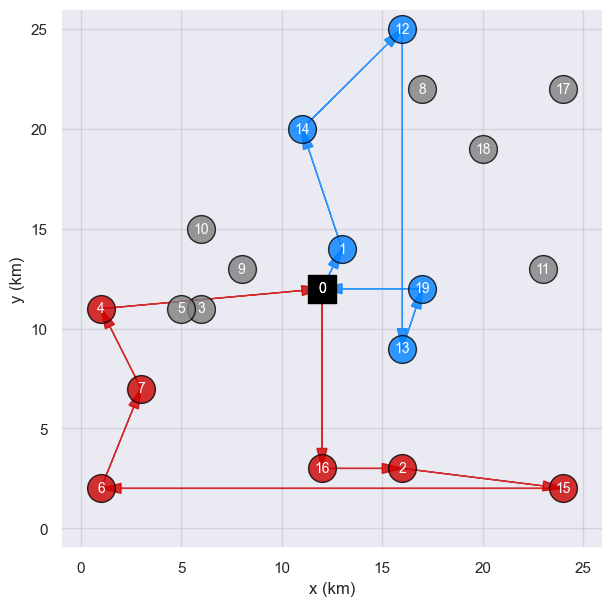

In [102]:
controls = dict(map_size=(25, 25), num_nodes=20, num_vehicle=2)
data = create_data_model(**controls)
routes = solve_routing_problem(data)
data["robot"] = select_robot_nodes()
data = reset_demands(data, **controls)
data = exclude_nodes(data, list(np.array(data["robot"]).reshape(-1)), routes)
routes = solve_routing_problem(data)

plot_map(routes, **controls)

### Drone & Robot VRP (Under Construction)

In [143]:
# 已分配好的負責 Node
print('- Vehicle:', data['vehicle'])
print('- Drone:', data['drone'])
print('- Robot:', data['robot'], '\n')

# 取得 drone 路徑 
drone_routes = get_drone_route()
print('\nRoute for Drone:',drone_routes ,'\n')

# 取得 drone 路徑
robot_routes = get_robot_route()
print('\nRoute for Robot:', robot_routes)

- Vehicle: [[0, 11, 3, 2, 13, 17, 16, 10, 15, 1, 0]]
- Drone: [19, 8]
- Robot: [[7, 5, 14, 18], [4, 6, 12, 9]] 

Node 19 assign to: 0;  Route: [13, 19, 17] (12)
Node 8 assign to: 0;  Route: [2, 8, 3] (7)

Route for Drone: [[[13, 19, 17], [3, 8, 2]]] 

Group [7, 5, 14, 18] assign to: 0;  Route: [2, 7, 5, 14, 18, 13] (22)
Group [4, 6, 12, 9] assign to: 0;  Route: [10, 4, 6, 12, 9, 15] (54)

Route for Robot: [[[2, 7, 5, 14, 18, 13], [10, 4, 6, 12, 9, 15]]]


- Vehicle: [[0, 11, 3, 2, 13, 17, 16, 10, 15, 1, 0]]
- Drone [[[13, 19, 17], [3, 8, 2]]]
- Robot: [[[2, 7, 5, 14, 18, 13], [10, 4, 6, 12, 9, 15]]]


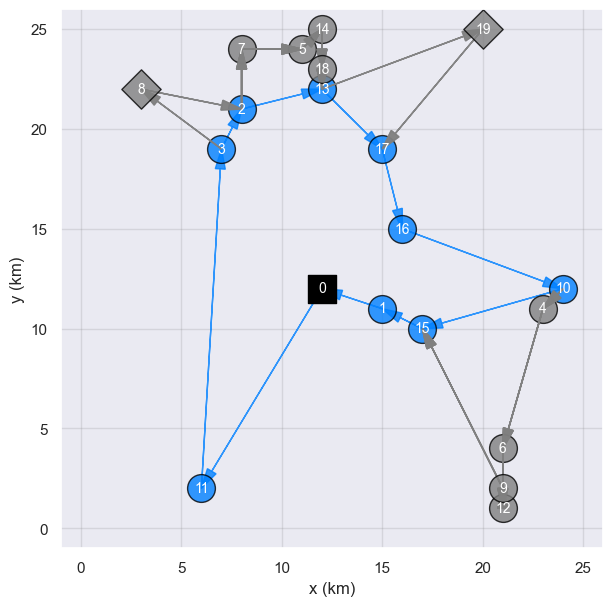

In [144]:
# 轉換預計成格式
print('- Vehicle:', routes)
print('- Drone', drone_routes)
print('- Robot:', robot_routes)

plot_map(routes, drone_routes, robot_routes)

## 待優化分群方法

In [91]:
'''
目前演算法會將同條路徑上的服務點分配給 Drone, 
可根據角度篩選掉 Truck 與 Drone 向量同方向的點
'''
controls = dict(map_size=(20, 20), num_nodes=10, num_vehicle=2, trials=10)
data = create_data_model(**controls)

# 計算角度: 計算 Drone 的返回點, 讓等待最小化
def calculate_angle(locations):
    A, B, C = locations[0], locations[1], locations[2]
    vector_AB = [B[0] - A[0], B[1] - A[1]] # 計算向量 AB 和 BC
    vector_BC = [C[0] - B[0], C[1] - B[1]]
    dot_product = vector_AB[0] * vector_BC[0] + vector_AB[1] * vector_BC[1] # 計算向量的點積和模長
    magnitude_AB = math.sqrt(vector_AB[0]**2 + vector_AB[1]**2)
    magnitude_BC = math.sqrt(vector_BC[0]**2 + vector_BC[1]**2)
    angle_radians = math.acos(dot_product / (magnitude_AB * magnitude_BC)) # 計算角度(以弧度為單位)
    angle_degrees = math.degrees(angle_radians) # 轉換為角度(以度為單位)
    
    return round(angle_degrees, 1)

test_route = [4,3,6]
locs = get_nodes(test_route)

calculate_angle(locs)

83.3

## 設定參數與記錄實驗結果

In [59]:
def create_result_model():
    
    result = {}    
    result["id"] = []
    result["map_size"] = []
    result["num_nodes"] = []
    result["num_locations"] = []
    result["num_vehicles"] = []
    result["vehicle_capacities"] = []
    # VRP
    result["VRP_routes"] = []
    result["VRP_distances"] = []
    result["VRP_time"] = []
    result["VRP_waiting"] = []
    result["VRP_time_complexity"] = []
    result["VRP_space_complexity"] = []
    # DVRP
    result["DVRP_routes"] = []
    result["DVRP_distances"] = []
    result["DVRP_time"] = []
    result["DVRP_waiting"] = []
    result["DVRP_time_complexity"] = []
    result["DVRP_space_complexity"] = []
    # RVRP
    # result["RVRP_routes"] = []
    # result["RVRP_distances"] = []
    # result["RVRP_time"] = []
    # result["RVRP_waiting"] = []
    # result["RVRP_solved"] = []
    # result["RVRP_time_complexity"] = []
    # result["RVRP_space_complexity"] = []     
    # DRVRP   
    # result["DRVRP_routes"] = []
    # result["DRVRP_distances"] = []
    # result["DRVRP_time"] = []
    # result["DRVRP_waiting"] = []
    # result["DRVRP_solved"] = []
    # result["DRVRP_time_complexity"] = []
    # result["DRVRP_space_complexity"] = []
    return result

In [81]:
def solve_by_VRP(data):
    start_time = time.time()
    tracemalloc.start()
    '''algorithm starts'''
    routes = solve_routing_problem(data)
    total_dist, travel_time, waiting_time = get_travelling_time(data, routes)
    '''algorithm ends'''
    end_time = time.time()
    current, peak = tracemalloc.get_traced_memory()
    tracemalloc.stop()
    time_complexity = round(end_time - start_time, 4)
    space_complexity = round(current / 1024, 4)
    # print(f"Time taken: {time_complexity} seconds")
    # print(f"Memory used: {space_complexity} KB")
    VRP_result = dict(VRP_routes=routes, VRP_distances=total_dist, VRP_time=travel_time, VRP_waiting=waiting_time, VRP_time_complexity=time_complexity, VRP_space_complexity=space_complexity)
    return VRP_result

def solve_by_DVRP(data):
    start_time = time.time()
    tracemalloc.start()
    '''algorithm starts'''
    routes = solve_routing_problem(data)
    data["drone"] = select_drone_nodes(data, routes)
    data = exclude_nodes(data, data["drone"], routes)
    routes = solve_routing_problem(data)
    drone_routes = get_drone_route(data, routes)
    # print('Route for Drone:',drone_routes)
    drone_waiting = get_waiting_time(data, routes, drone_routes, 'drone')
    robot_waiting = [[] for i in range(len(drone_waiting))]
    total_dist, travel_time, waiting_time = get_travelling_time(data, routes, drone_waiting, robot_waiting)
    '''algorithm ends'''
    end_time = time.time()
    current, peak = tracemalloc.get_traced_memory()
    tracemalloc.stop()
    time_complexity = round(end_time - start_time, 4)
    space_complexity = round(current / 1024, 4)
    DVRP_result = dict(DVRP_routes=routes, DVRP_distances=total_dist, DVRP_time=travel_time, DVRP_waiting=waiting_time, DVRP_time_complexity=time_complexity, DVRP_space_complexity=space_complexity)
    return DVRP_result


# 地圖大小, 客戶點數量, 車輛數, 模擬次數
def simulate_experiment(**controls):

    for iter in range(1, controls["trials"]+1):
        
        print(f'Trial {iter}...')
        # 根據實驗變數建立 Model
        data = create_data_model(**controls)
        result["id"].append(len(result["id"])+1)
        result["map_size"].append((controls["map_size"][0], controls["map_size"][1]))
        result["num_nodes"].append(data["num_nodes"])
        result["num_locations"].append(data["num_locations"])
        result["num_vehicles"].append(data["num_vehicles"])
        result["vehicle_capacities"].append(data["vehicle_capacities"])
        # VRP
        VRP_result = solve_by_VRP(data)
        result["VRP_routes"].append(VRP_result["VRP_routes"])
        result["VRP_distances"].append(VRP_result["VRP_distances"])
        result["VRP_time"].append(VRP_result["VRP_time"])
        result["VRP_waiting"].append(VRP_result["VRP_waiting"])
        result["VRP_time_complexity"].append(VRP_result["VRP_time_complexity"])
        result["VRP_space_complexity"].append(VRP_result["VRP_space_complexity"])
        # DVRP
        DVRP_result = solve_by_DVRP(data)
        result["DVRP_routes"].append(DVRP_result["DVRP_routes"])
        result["DVRP_distances"].append(DVRP_result["DVRP_distances"])
        result["DVRP_time"].append(DVRP_result["DVRP_time"])
        result["DVRP_waiting"].append(DVRP_result["DVRP_waiting"])        
        result["DVRP_time_complexity"].append(DVRP_result["DVRP_time_complexity"])
        result["DVRP_space_complexity"].append(DVRP_result["DVRP_space_complexity"])
        # RVRP
        # DRVRP

    print('\nDone!')

In [66]:
# 記錄結果
result = create_result_model()

In [82]:
# 設定實驗參數 & 實驗
controls = dict(map_size=(20, 20), num_nodes=10, num_vehicle=2, trials=10)
simulate_experiment(**controls)

Trial 1...
Trial 2...
Trial 3...
Trial 4...
Trial 5...
Trial 6...
Trial 7...
Trial 8...
Trial 9...
Trial 10...

Done!


In [83]:
pd.DataFrame(result).head()

,id,map_size,num_nodes,num_locations,num_vehicles,vehicle_capacities,VRP_routes,VRP_distances,VRP_time,VRP_waiting,VRP_time_complexity,VRP_space_complexity,DVRP_routes,DVRP_distances,DVRP_time,DVRP_waiting,DVRP_time_complexity,DVRP_space_complexity
0,1,"(20, 20)",10,"[(10, 10), (2, 4), (9, 6), (9, 14), (12, 10), ...",2,"[4, 4]","[[0, 2, 6, 5, 4, 0], [0, 7, 1, 8, 9, 3, 0]]",89,56,0,0.1820,1.9434,"[[0, 4, 9, 3, 0], [0, 7, 1, 2, 6, 0]]",67,43.0,6.0,0.3389,2.0049
1,2,"(20, 20)",10,"[(10, 10), (14, 16), (19, 11), (5, 7), (13, 13...",2,"[4, 4]","[[0, 2, 6, 9, 1, 4, 0], [0, 7, 3, 5, 8, 0]]",85,44,0,0.1140,0.9346,"[[0, 6, 2, 1, 4, 0], [0, 7, 3, 5, 0]]",65,37.0,0.0,0.2147,2.0996
2,3,"(20, 20)",10,"[(10, 10), (8, 18), (6, 15), (16, 4), (12, 17)...",2,"[4, 4]","[[0, 4, 9, 6, 3, 8, 0], [0, 7, 1, 5, 2, 0]]",89,50,0,0.1116,0.9346,"[[0, 7, 1, 2, 0], [0, 6, 3, 9, 4, 0]]",75,47.0,15.0,0.2850,2.1465
3,4,"(20, 20)",10,"[(10, 10), (15, 8), (10, 1), (14, 2), (20, 4),...",2,"[4, 4]","[[0, 2, 3, 4, 1, 0], [0, 7, 5, 9, 6, 8, 0]]",97,54,0,0.1886,0.3896,"[[0, 1, 3, 2, 0], [0, 7, 9, 6, 5, 0]]",77,47.0,15.0,0.2351,1.7617
4,5,"(20, 20)",10,"[(10, 10), (4, 5), (3, 4), (1, 16), (11, 2), (...",2,"[4, 4]","[[0, 3, 8, 6, 9, 0], [0, 1, 2, 7, 4, 5, 0]]",81,43,0,0.1240,0.8809,"[[0, 9, 3, 8, 0], [0, 1, 2, 7, 4, 0]]",79,42.0,0.0,0.2697,2.1230
